# Fitting an ODE model to longitudinal data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
import string
import pickle
from tqdm import tqdm
from datetime import datetime
from lmfit import minimize, Parameters
import multiprocess as mp

# Import my own libraries
import myUtils as utils
from odeModelClass import ODEModel
from odeModels import create_model
from fittingUtils import residual, compute_r_sq, load_fit, generate_fitSummaryDf, perform_bootstrap, \
                            compute_confidenceInterval_prediction, compute_confidenceInterval_parameters

# Format plots
sns.set(style="white",
        font_scale=1.5,
        rc={'figure.figsize':(8,6)})

In [2]:
# Data and solver configurations
dataDfName = "./data.csv"
patientIdList = np.arange(12)
runFitting = True

# Environment
out_dir = "./models/"
GDRSPalette = {"TumourSize":sns.xkcd_rgb['ocean blue'],
              "V":'k',
              "G":'g'}
sensitiveResistantPalette = {"S": "#0F4C13",
                             "R": "#710303",
                             "TumourSize":sns.xkcd_rgb['ocean blue']}

## Code

In [3]:
def load_patient_data(patientId=None, pathToData=dataDfName):
    # Load data
    currDataDf = pd.read_csv(pathToData)
    currDataDf.rename(columns={"index.time":"Time", "CA125.measure":"CA125"}, inplace=True)
    # Annotate patients with numeric rather than alphabetic Ids
    patientList = list(currDataDf['Case'].unique())
    currDataDf['PatientId'] = currDataDf.apply(lambda x: patientList.index(x['Case']),axis=1)
    # Parse CA125 data. Need to convert undetectable values, and convert to numeric
    currDataDf['Detectable'] = currDataDf['CA125'] != "<15"
    currDataDf['CA125'].replace(to_replace="<15", value="15", inplace=True)
    currDataDf['CA125'] = pd.to_numeric(currDataDf['CA125'])
    # Parse treatment data
    currDataDf['Treatment'] = np.isin(currDataDf['therapy.status'],['pre.chemo','off.chemo'])==False
    currDataDf['DrugConcentration'] = currDataDf['Treatment']*1
    currDataDf['TreatmentCycleId'] = [x.split("chemo")[-1] for x in currDataDf['therapy.status']]
    if patientId is not None: currDataDf = currDataDf[currDataDf['PatientId']==patientId].copy()
    # Normalise
    refValue = currDataDf['CA125'].iloc[np.argmin(np.abs(currDataDf['Time']))]
    currDataDf['CA125_normalised'] = currDataDf['CA125']/refValue
    currDataDf.reset_index(inplace=True)
    return currDataDf

In [4]:
def plot_data(dataDf, timeColumn="Time", feature='BRAF V600E (copies/ul)', treatmentColumn="DrugConcentration",
              hue=None, style=None, legend=False, palette=None,
              plotDrug=True, plotDrugAsBar=False, drugBarPosition=0.85,
              drugColorMap={"Encorafenib": "blue", "Binimetinib": "green", "Nivolumab": sns.xkcd_rgb["goldenrod"]},
              xlim=None, ylim=None, y2lim=1,
              markInitialSize=False, markPositiveCutOff=False, plotHorizontalLine=False, lineYPos=1, despine=False,
              titleStr="", decorateX=True, decorateY=True, decorateY2=True,
              markersize=10, linestyle="None", linecolor='black',
              ax=None, figsize=(10, 8), outName=None, **kwargs):
    '''
    Plot longitudinal treatment data, together with annotations of drug administration and events responsible for
    changes in treatment dosing (e.g. toxicity).
    :param dataDf: Pandas data frame with longitudinal data to be plotted.
    :param timeColumn: Name (str) of the column with the time information.
    :param feature: Name (str) of the column with the metric to be plotted on the y-axis (e.g. PSA, CA125, etc).
    :param treatmentColumn: Name (str) of the column with the information about the dose administered.
    :param plotDrug: Boolean; whether or not to plot the treatment schedule.
    :param plotDrugAsBar: Boolean, whether to plot drug as bar across the top, or as shading underneath plot.
    :param drugBarPosition: Position of the drug bar when plotted across the top.
    :param drugColorMap: Color map for colouring the shading when using different drugs.
    :param lw_events: Line width for vertical event lines.
    :param xlim: x-axis limit.
    :param ylim: y-axis limit.
    :param y2lim: y2-axis limit.
    :param markInitialSize: Boolean, whether or not to draw horizontal line at height of fist data point.
    :param plotHorizontalLine: Boolean, whether or not to draw horizontal line at position specified at lineYPos.
    :param lineYPos: y-position at which to plot horizontal line.
    :param despine: Boolean, whether or not to despine the plot.
    :param titleStr: Title to put on the figure.
    :param decorateX: Boolean, whether or not to add labels and ticks to x-axis.
    :param decorateY: Boolean, whether or not to add labels and ticks to y-axis.
    :param decorateY2: Boolean, whether or not to add labels and ticks to y2-axis.
    :param markersize: Size of markers for feature variable.
    :param linestyle: Feature variable line style.
    :param linecolor: Feature variable line color.
    :param ax: matplotlib axis to plot on. If none provided creates a new figure.
    :param figsize: Tuple, figure dimensions when creating new figure.
    :param outName: Name under which to save figure.
    :param kwargs: Other kwargs to pass to plotting functions.
    :return:
    '''
    if ax is None: fig, ax = plt.subplots(1, 1, figsize=figsize)
    # Plot the data
    sns.lineplot(x=timeColumn, y=feature, hue=hue, style=style,
                 color=linecolor, legend=legend, palette=palette,
                 marker='o', markersize=markersize, markeredgewidth=2,
                 ax=ax, data=dataDf)

    # Plot the drug concentration
    if plotDrug:
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        if plotDrugAsBar:
            drugConcentrationVec = utils.TreatmentListToTS(
                treatmentList=utils.ExtractTreatmentFromDf(dataDf, timeColumn=timeColumn,
                                                           treatmentColumn=treatmentColumn),
                tVec=dataDf[timeColumn])
            drugConcentrationVec[drugConcentrationVec < 0] = 0
            drugConcentrationVec = np.array([x / (np.max(drugConcentrationVec) + 1e-12) for x in drugConcentrationVec])
            drugConcentrationVec = drugConcentrationVec / (1 - drugBarPosition) + drugBarPosition
            ax2.fill_between(dataDf[timeColumn], drugBarPosition, drugConcentrationVec,
                             step="post", color="black", alpha=1., label="Drug Concentration")
            ax2.axis("off")
        else:
            currDrugBarPosition = drugBarPosition
            drugBarHeight = (1-drugBarPosition)/len(drugColorMap.keys())
            for drug in drugColorMap.keys():
                drugConcentrationVec = utils.TreatmentListToTS(
                    treatmentList=utils.ExtractTreatmentFromDf(dataDf, timeColumn=timeColumn,
                                                               treatmentColumn="%s Dose (mg)"%drug),
                    tVec=dataDf[timeColumn])
                drugConcentrationVec[drugConcentrationVec < 0] = 0
                # Normalise drug concentration to 0-1 (1=max dose(=initial dose))
                drugConcentrationVec = np.array([x / (np.max(drugConcentrationVec) + 1e-12) for x in drugConcentrationVec])
                # Rescale to make it fit within the bar at the top of the plot
                drugConcentrationVec = drugConcentrationVec * drugBarHeight + currDrugBarPosition
                ax2.fill_between(dataDf[timeColumn], currDrugBarPosition, drugConcentrationVec, step="post",
                                 color=drugColorMap[drug], alpha=0.5, label="Drug Concentration")
                ax2.hlines(xmin=dataDf[timeColumn].min(), xmax=dataDf[timeColumn].max(), 
                          y=currDrugBarPosition, linewidth=3, color="black")
                currDrugBarPosition += drugBarHeight
            # Line at the top of the drug bars
            ax2.hlines(xmin=dataDf[timeColumn].min(), xmax=dataDf[timeColumn].max(), 
                          y=currDrugBarPosition, linewidth=3, color="black")
        # Format y2 axis
        if y2lim is not None: ax2.set_ylim([0, y2lim])
        ax2.tick_params(labelsize=28)
        if not decorateY2:
            ax2.set_yticklabels("")

    # Format the plot
    if xlim is not None: ax.set_xlim(0, xlim)
    if ylim is not None: ax.set_ylim(0, ylim)
    if despine: sns.despine(ax=ax, trim=True, offset=50)

    # Draw horizontal lines (e.g. initial size)
    if plotHorizontalLine or markInitialSize or markPositiveCutOff:
        xlim = ax.get_xlim()[1]
        if markInitialSize: lineYPos = dataDf.loc[dataDf[timeColumn] == 0, feature]
        if markPositiveCutOff: lineYPos = 0.5 # cut-off value for positive is 0.5 copies/uL
        ax.hlines(xmin=0, xmax=xlim, y=lineYPos, linestyles=':', linewidth=4)

    # Decorate the plot
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(titleStr)
    ax.tick_params(labelsize=28)
    if not decorateX:
        ax.set_xticklabels("")
    if not decorateY:
        ax.set_yticklabels("")
    plt.tight_layout()
    if outName is not None: plt.savefig(outName)

## Plot Data

### Plot individual patients

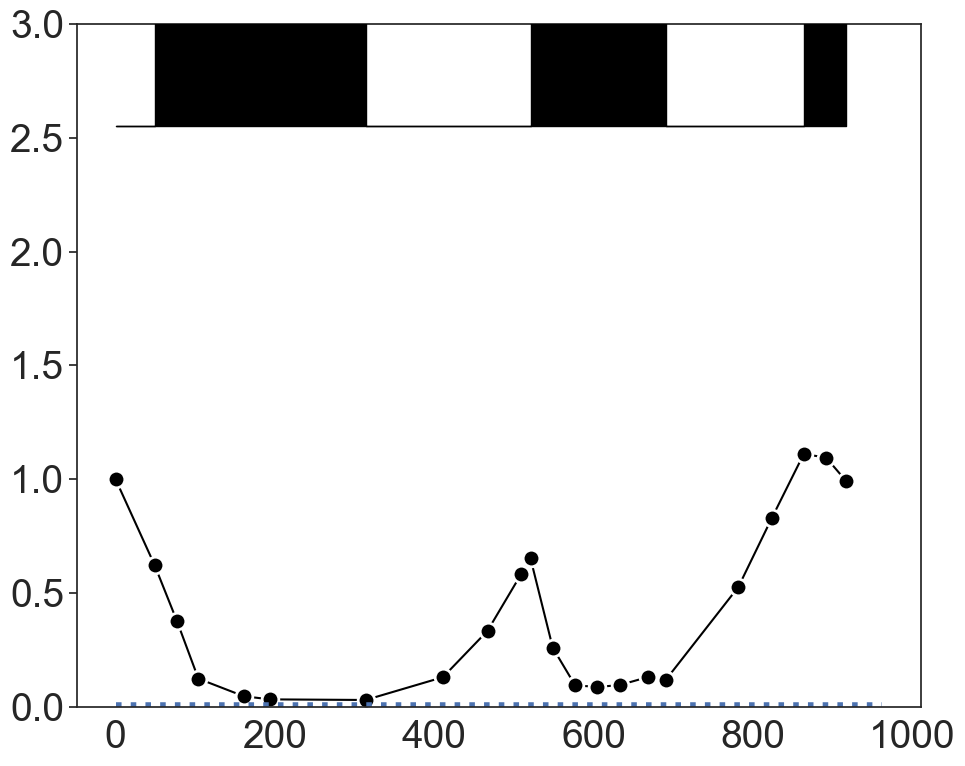

In [9]:
patientId = 4

fig,ax = plt.subplots(1,1,figsize=(10,8))
dataDf = load_patient_data(patientId=patientId,pathToData=dataDfName)
# dataDf = dataDf[dataDf.Time<250]
plot_data(dataDf,timeColumn="Time",feature="CA125_normalised",treatmentColumn="Treatment", ylim=3.,
          plotDrugAsBar=True,
          plotHorizontalLine=True, lineYPos=35/dataDf.loc[dataDf['CA125_normalised']==1,'CA125'].values[0],
          markersize=12,linestyle="-",markInitialSize=False,
          ax=ax)

### Overview all patients

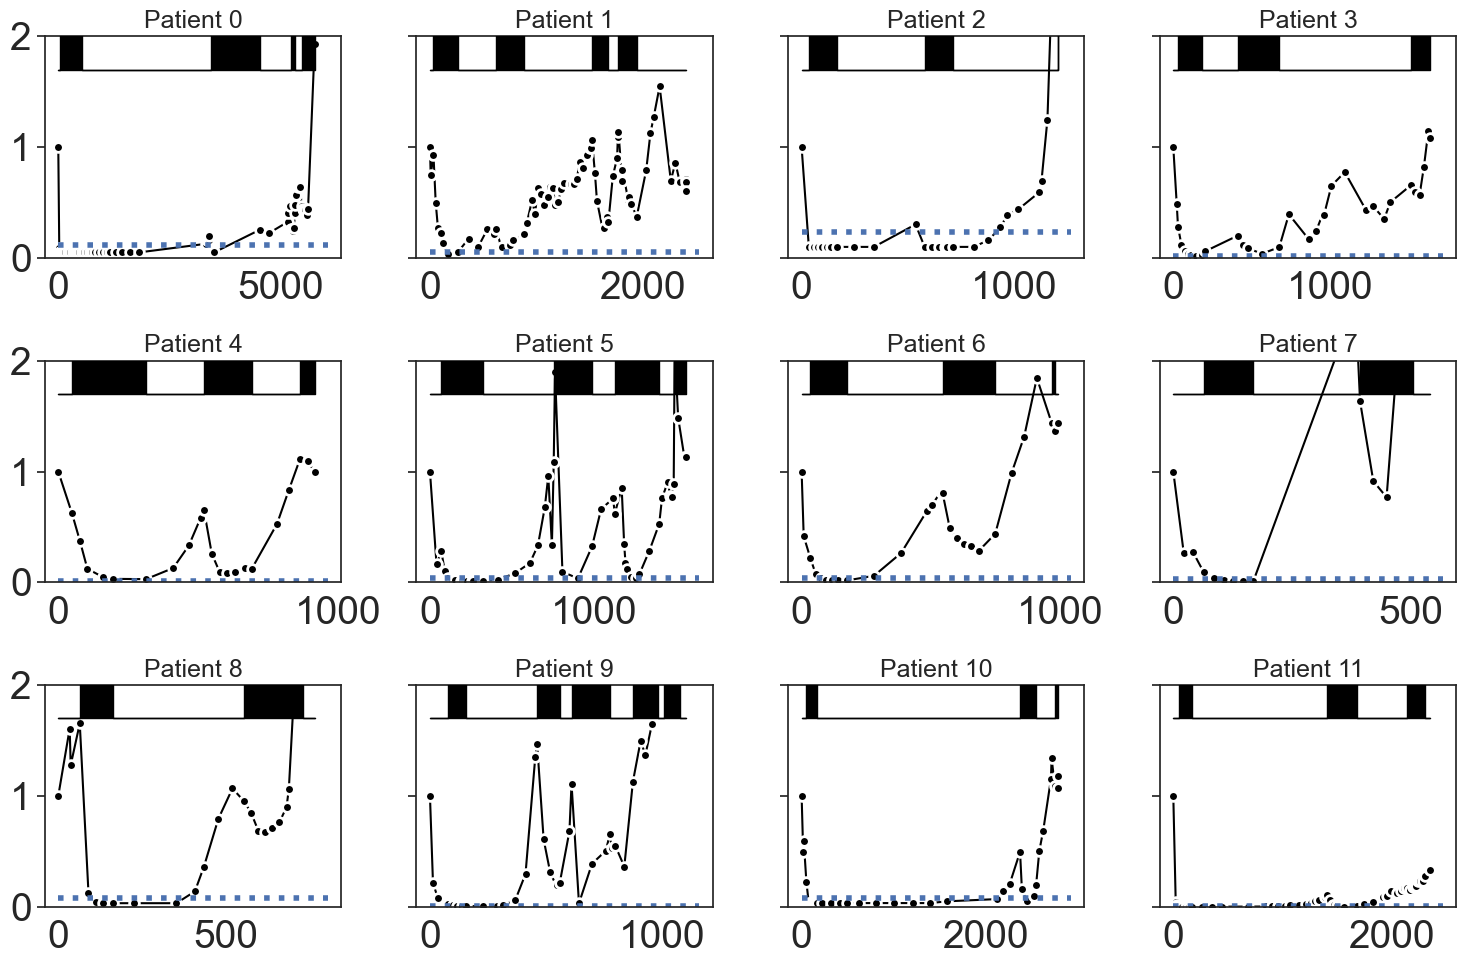

In [11]:
fig, axList = plt.subplots(3,4,sharex=False,sharey=True,figsize=(15,10))
for i,patientId in enumerate(patientIdList):
    currAx = axList.flatten()[i]
    currDataDf = load_patient_data(patientId,pathToData=dataDfName)
    plot_data(currDataDf,timeColumn="Time",feature="CA125_normalised",treatmentColumn="Treatment", ylim=2.,
              plotDrugAsBar=True,
              plotHorizontalLine=True, lineYPos=35/currDataDf.loc[currDataDf['CA125_normalised']==1,'CA125'].values[0],
              markersize=7,linestyle="-",markInitialSize=False,
              titleStr="Patient %d"%patientId,
              ax=currAx)
plt.tight_layout()

## Fit the GDRS model

### Experiment with the model

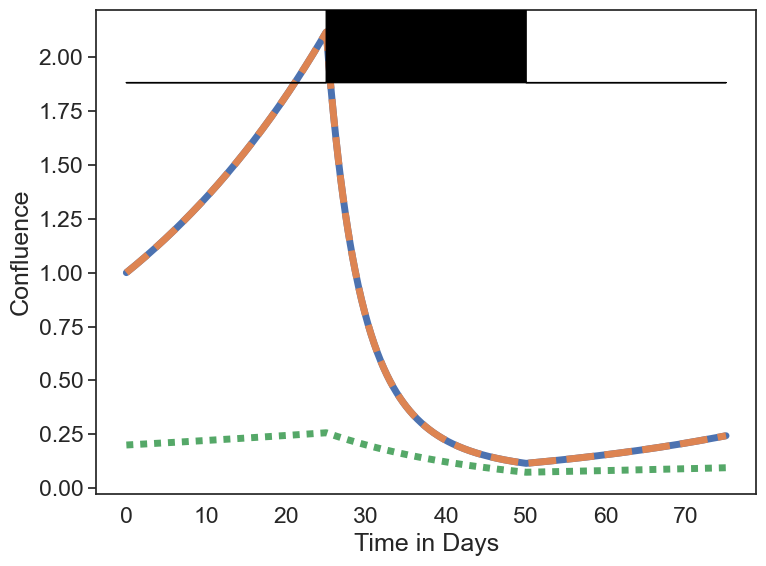

In [12]:
myModel = create_model("GDRSModel")
myModel.SetParams(G0=0.2, epsilon=0.05, beta=0.01)
myModel.Simulate(treatmentScheduleList=[[0,25,0],[25,50,1],[50,75,0]])
myModel.Trim(dt=.1)
myModel.Plot(plotPops=True)

### Fitting

In [6]:
patientsToAnalyseList = [6, 8]
solver_kws={'method':'RK45', 'absErr':1.0e-10, 'relErr':1.0e-10, 'suppressOutputB':False, 'max_step':10}
optimiser_kws = {'method':'least_squares', 'xtol':1e-8, 'ftol':1e-8, 'max_nfev':200,
                 'nan_policy':'omit', 'verbose':2}

# Model parameters
model_name = "GDRSModel"
params = Parameters()
params.add('r', value=5e-4, min=0, max=0.1, vary=True)
params.add('epsilon', value=5e-2, min=0, max=0.1, vary=True)
params.add('beta', value=0, min=0, max=5e-1, vary=False)
params.add('V0', value=50, min=0, max=10000, vary=False)
params.add('G0', value=1e-1, min=0, max=1, vary=False)
params.add('DMax', value=1, vary=False)
working_dir = os.path.join(out_dir, model_name)

In [7]:
for patientId in patientsToAnalyseList:
    # Load data
    training_data_df = load_patient_data(patientId=patientId,pathToData=dataDfName)
    
    # Setup env
    curr_out_dir = os.path.join(working_dir,"patient%d"%patientId)
    utils.mkdir(curr_out_dir)
    tmp_model = create_model(model_name)
    curr_params = Parameters()
    curr_params.add_many(*[params[x] for x in tmp_model.paramDic.keys()])   
    # Set up initial conditions
    if params['V0'].vary==False: curr_params['V0'].value = training_data_df.CA125.iloc[0]

    # Fit
    tmp_model.SetParams(**curr_params)
    fit_obj = minimize(residual, curr_params, args=(0, training_data_df, tmp_model, {"V":"CA125"}, solver_kws),
                       **optimiser_kws)
    fit_obj.fitId = 0
    fit_obj.numericalStabilisation = tmp_model.numericalStabilisationB
    fit_obj.modelName = model_name
    fit_obj.data = training_data_df
    fit_obj.rSq = compute_r_sq(fit_obj, training_data_df, feature="CA125")

    # Post-process
    pickle.dump(obj=fit_obj, file=open(os.path.join(curr_out_dir, "fitObj_fit_%d.p"%(fit_obj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.7939e+06                                    1.13e+08    
       1              3         1.3585e+06      2.44e+06       1.48e-03       1.67e+08    
       2              4         9.0220e+05      4.56e+05       2.15e-03       1.90e+06    
       3              5         8.6227e+05      3.99e+04       2.53e-03       2.97e+06    
       4              6         8.5919e+05      3.08e+03       3.10e-03       7.97e+06    
       5              7         8.5866e+05      5.28e+02       2.95e-04       7.22e+04    
       6              8         8.5866e+05      6.23e-02       7.55e-06       4.31e+02    
       7              9         8.5866e+05      1.65e-04       6.46e-07       2.46e+00    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 3.7939e+06, final cost 8.5866e+05, first-order optimality 2.46e+00.
   Iteration     Total nfev      

In [16]:
# Plot individual fit results to do some quality control (convergence, correlation structures etc)
fitObj

### Plot Fit

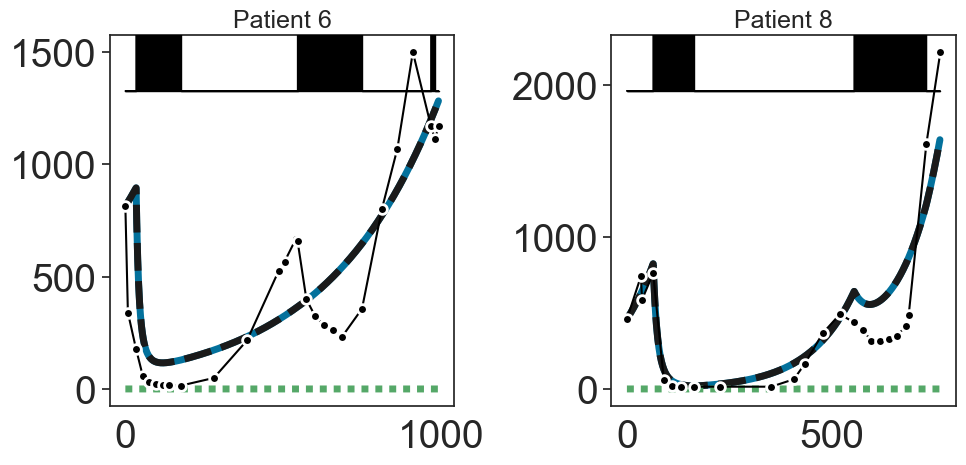

In [8]:
fig, ax_list = plt.subplots(1,2,sharex=False,sharey=False,figsize=(10,5))
for i,patientId in enumerate(patientsToAnalyseList):
    currAx = ax_list[i]
    fitObj,myModel = load_fit(model_name,fitDir=os.path.join(working_dir,"patient%d"%patientId),
                             model=create_model(model_name))
    myModel.Simulate(treatmentScheduleList=utils.ExtractTreatmentFromDf(fitObj.data),**solver_kws)
    myModel.Trim(dt=1)
    myModel.Plot(plotPops=True, ymin=0, linewidth=2, palette=GDRSPalette, 
                 decoratey2=False, decorateAxes=False, ax=currAx)
    plot_data(fitObj.data,timeColumn="Time",feature="CA125",treatmentColumn="Treatment", #ylim=2.,
          plotDrugAsBar=True,
          markersize=7,linestyle="-",markInitialSize=False,
          titleStr="Patient %d"%patientId,
          ax=currAx)
plt.tight_layout()

### Estimate uncertainty in parameter estimates and model predictions by parametric bootstrapping

In [9]:
n_processes = 4
n_bootstraps = 5
significance_level_ci = 0.95

In [10]:
# Due to the random perturbations during bootstrapping the ODE solver can fail whilst fitting 
# to the synthetic data. To fix this, use more stringent solver arguments
solver_kws_bootstrapping = solver_kws.copy()
solver_kws_bootstrapping['max_step'] = 1

# Turn off verboseness for bootstrapping
optimiser_kws_bootstrapping = optimiser_kws.copy()
optimiser_kws_bootstrapping['verbose'] = 0

# Use multi-threading to speed up computation. 
pool = mp.Pool(processes=n_processes)
def run_boostrap_job(job):
    fit_obj, out_name = job
    return perform_bootstrap(fit_obj, n_bootstraps=n_bootstraps, 
                             model_to_observation_map={"V":"CA125"},
                             shuffle_params=True,
                             show_progress=True, #plot_bootstraps=True,
                             solver_kws=solver_kws_bootstrapping, 
                             optimiser_kws=optimiser_kws_bootstrapping, 
                             outName=out_name)

job_list = []
for patientId in patientsToAnalyseList:      
    curr_out_dir = os.path.join(working_dir,"patient%d"%patientId)
    fit_obj,_ = load_fit(model_name, fitDir=curr_out_dir)
    job_list.append([fit_obj,os.path.join(curr_out_dir, "bootstraps_fit_%d.csv"%fit_obj.fitId)])
#     [run_boostrap_job(x) for x in job_list]
list(tqdm(pool.imap(run_boostrap_job, job_list), total=len(job_list)));

100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.89s/it]


### Plot predictions with confidence intervals

In [11]:
tmp_list = []
for patientId in patientsToAnalyseList:      
    curr_out_dir = os.path.join(working_dir,"patient%d"%patientId)
    fit_obj, _, bootstrap_df = load_fit(model_name, fitDir=curr_out_dir, load_bootstraps=True)        
    curr_training_data_df = fit_obj.data.copy()

    # Generate predictions
    predictions_df = compute_confidenceInterval_prediction(fitObj=fit_obj, 
                                                        bootstrapResultsDf=bootstrap_df,
                                                        treatmentScheduleList=utils.ExtractTreatmentFromDf(curr_training_data_df),
#                                                         initialConditionsDic=initial_conditions_dic,
                                                        show_progress=True, n_time_steps=100,
                                                        alpha=significance_level_ci,
                                                        solver_kws=solver_kws, optimiser_kws=optimiser_kws)
    predictions_df['PatientId'] = patientId
    tmp_list.append(predictions_df)
predictions_df_all = pd.concat(tmp_list)

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 13.52it/s]
/Users/maxi/miniconda3/envs/python3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/maxi/miniconda3/envs/python3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:4529: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/maxi/miniconda3/envs/python3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:4530: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)
100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 18.66it/s]
/Users/maxi/miniconda3/envs/python3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:4529: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=ou

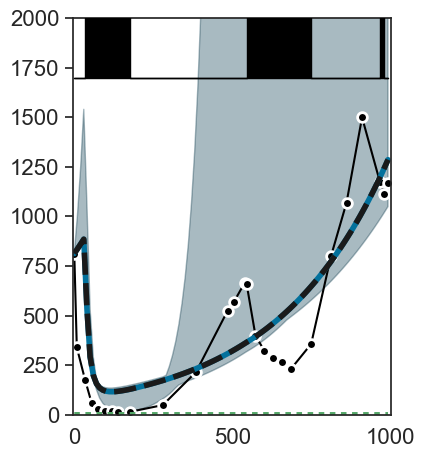

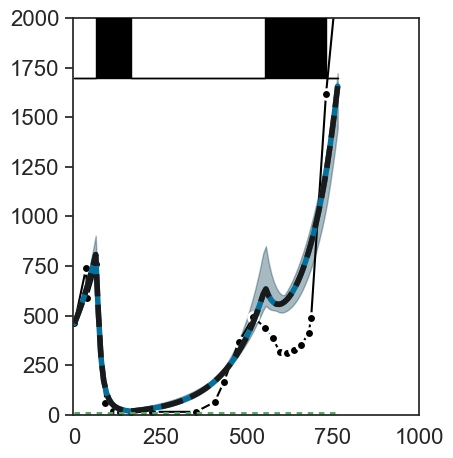

In [12]:
# Plot
xmax = 1000
ymax = 2e3 # 5e4 for log
model_palette = GDRSPalette

for patientId in patientsToAnalyseList:
    fig, ax = plt.subplots(1,1,sharex=False,sharey=False,figsize=(5,5))
    curr_predictions_df = predictions_df_all[(predictions_df_all.PatientId==patientId)]
    curr_trainingData_df_all = training_data_df = load_patient_data(patientId=patientId,pathToData=dataDfName)
    
    # 1. Plot the data
    plot_data(curr_trainingData_df_all, timeColumn="Time", feature="CA125",
              treatmentColumn="Treatment", plotDrugAsBar=True,
          markersize=7,linestyle="-",markInitialSize=False, ax=ax)
    
#     plot_data(curr_trainingData_df_all, timeColumn="Time", feature="CA125", 
#               treatmentColumn="DrugConcentration",
#               markersize=8, linestyle="-", ax=ax)

    # 2. Plot the model predictions for the mean
    sns.lineplot(x="Time", y="Estimate_MLE", hue="Variable", style="Variable",
                 lw=4, palette=model_palette,
                 legend=False,
                 data=curr_predictions_df, ax=ax)
    for var in model_palette.keys():
        curr_df = curr_predictions_df[curr_predictions_df.Variable==var].copy()
        ax.fill_between(curr_df.Time, curr_df['CI_Lower_Bound'], 
                         curr_df['CI_Upper_Bound'], color=model_palette[var], alpha=0.2)

    # 3. Indicate which data was used for training
    ax.tick_params(labelsize=16)
    ax.set_ylim(0,ymax)
    ax.set_xlim(-5, xmax)
#     ax.set_ylim(1e2,ymax)
#     ax.set_yscale('symlog')
    ax.set_xlabel("")
    ax.set_ylabel("")
# plt.savefig("./figures/mono_culture_predictions_%s_%s_all.pdf"%(model_name, drug_name))

### Plot parameter estimates

In [17]:
tmp_list = []
for patientId in patientsToAnalyseList:      
    curr_out_dir = os.path.join(working_dir,"patient%d"%patientId)
    fit_obj, _, bootstrap_df = load_fit(model_name, fitDir=curr_out_dir, load_bootstraps=True)        
    tmp_df = compute_confidenceInterval_parameters(fit_obj, bootstrap_df, 
                                                   paramsToEstimateList=['r', 'epsilon'], alpha=significance_level_ci)
    tmp_df['PatientId'] = patientId
    tmp_list.append(tmp_df)
parameter_df = pd.concat(tmp_list)

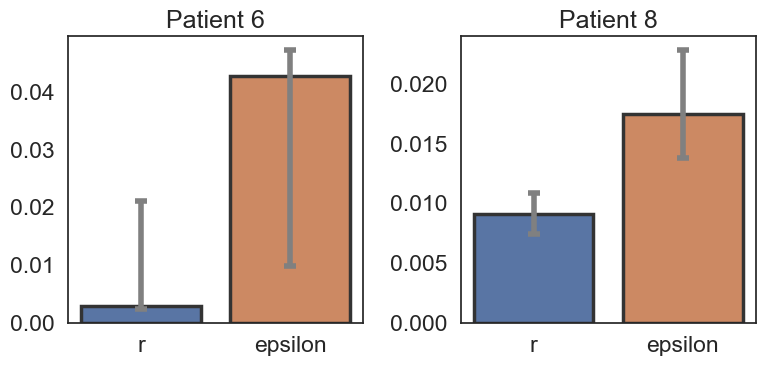

In [26]:
fig, ax_list = plt.subplots(1, 2, figsize=(8,4))
pars = ['r', 'epsilon']
for i, patientId in enumerate(patientsToAnalyseList):
    ax = ax_list[i]
    curr_df = parameter_df[(np.isin(parameter_df.Parameter, pars)) & (parameter_df.PatientId==patientId)]
    sns.barplot(x="Parameter", y="Estimate_MLE",
                edgecolor=".2",linewidth=2.5,
    #             palette=parameter_palette,
                data=curr_df, ax=ax)
    # Extract and plot error bars
    ax.errorbar(x=np.arange(curr_df.shape[0]), 
                y=curr_df["Estimate_MLE"],
                yerr=np.array([curr_df['Estimate_MLE']-curr_df['Lower_Bound'],
                               curr_df['Upper_Bound']-curr_df['Estimate_MLE']]), 
                fmt='none', c='grey', capsize=4, elinewidth=4, capthick=4)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Patient %d"%patientId)
    plt.tight_layout()
    # plt.savefig("./figures/parameters_%s_%s.pdf"%(model_name, drug_name))